In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import add
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from nltk.corpus import stopwords
from collections import Counter
import spacy
from spacy.tokenizer import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
nlp = spacy.load('fr_core_news_md') # sm moi j'ai  ?  md est beaucoup plus efficace en terme de résultats

## Importations des données

Nous importons un dataframe contenant uniquement 500 discours politiques ou déclaration. Les autres types d'élocutions n'ont pas été sélectionnées. Nous avons gardé du genre dans notre corpus de documents

In [77]:
df = pd.read_csv('minimal_df.csv')

Clean encodage

In [78]:
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80',''))

In [79]:
len(df)

500

In [80]:
df.columns

Index(['Unnamed: 0', 'Id', 'Titre', 'Type', 'Theme', 'Prenom', 'Nom',
       'Fonction', 'Date', 'Tags', 'Texte', 'Lien', 'sexe'],
      dtype='object')

La variable que nous souhaitons classifier à l'aide des discours est le sexe. Dans un premier temps intéressons nous aux variables qui ne sont pas propres au texte.

In [81]:
df.sexe.map(str).value_counts()

1    361
2    139
Name: sexe, dtype: int64

In [82]:
len(df)

500

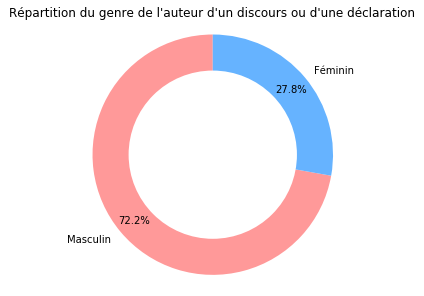

In [109]:
labels = ['Masculin','Féminin']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
sizes = [ len(df[df.sexe ==1]),len(df[df.sexe ==2])]
fig, ax1 = plt.subplots()
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition du genre de l'auteur d'un discours ou d'une déclaration")
plt.show()

In [84]:
df['Annee']= df.Date.map(str).apply(lambda x:x[:4])


In [85]:
lst=[]
for an in df.Annee.unique():
    for s in df.sexe.unique():
        if s == 1:
            sexe= 'Masculin'
        else:
            sexe='Féminin'
        lst+=[(an,len(df[(df.Annee == an) & (df.sexe == s)]),sexe)]
data = pd.DataFrame(lst,columns=['Annee','Nb','Sexe'])
# Ou alors faut changer la et mettre elif sexe=2 

Text(0.5, 1.0, "Evolution du nombre d'élocutions par sexe de 1980 à aujourd'hui")

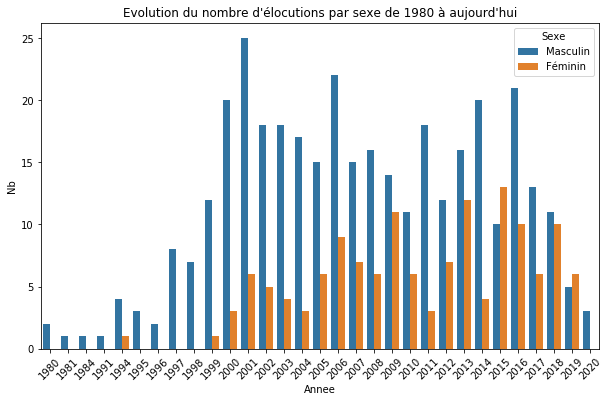

In [87]:
plt.figure(figsize=(10,6))
sns.barplot(data = data,
            x='Annee',
            y='Nb',
           hue='Sexe')
plt.xticks(rotation = 45)
plt.title("Evolution du nombre d'élocutions par sexe de 1980 à aujourd'hui")

In [97]:
df.Tags.fillna('',inplace=True)
arr =df[df.sexe == 2].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Féminin'
arr =df[df.sexe == 1].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Masculin'
d = pd.concat([d_f,d_m])

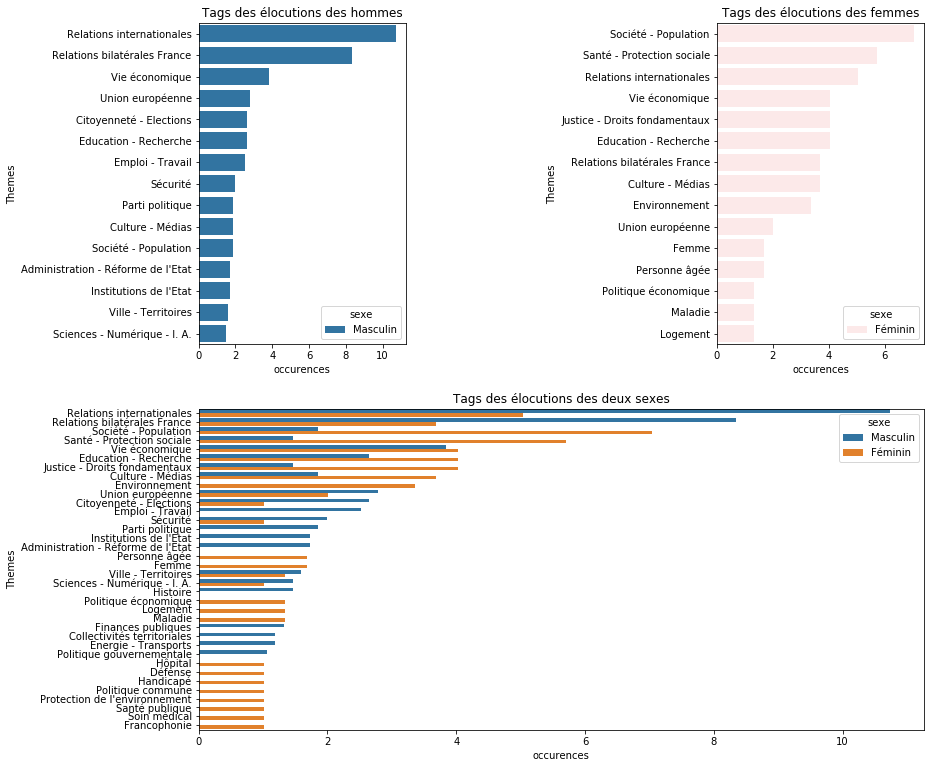

In [108]:
plt.figure(figsize=(13,13))
plt.subplot(221)
sns.barplot(data = d[(d.occurences >= 0.5) & (d.Themes.apply(len) >0) & (d.sexe == 'Masculin')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           hue='sexe')
plt.title("Tags des élocutions des hommes")
plt.subplot(222)
sns.barplot(data = d[(d.occurences >= 0.6) & (d.Themes.apply(len) >0) & (d.sexe == 'Féminin')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           hue='sexe',
           color = 'red')
plt.title("Tags des élocutions des femmes")
plt.subplot(212)
sns.barplot(data = d[(d.occurences >= 1) & (d.Themes.apply(len) >0)].sort_values('occurences',ascending=False),
            y='Themes',
            x='occurences',
           hue='sexe')
plt.title("Tags des élocutions des deux sexes")
plt.subplots_adjust(wspace = 1.5)

# La aussi faudrait le faire en pourcentage du total 
# C'est fait, il faut juste corriger le troisieme graph

In [143]:
# THEMES
df.Theme.fillna('',inplace=True)
arr =df[df.sexe == 2].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Féminin'
arr =df[df.sexe == 1].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Masculin'
d = pd.concat([d_f,d_m])

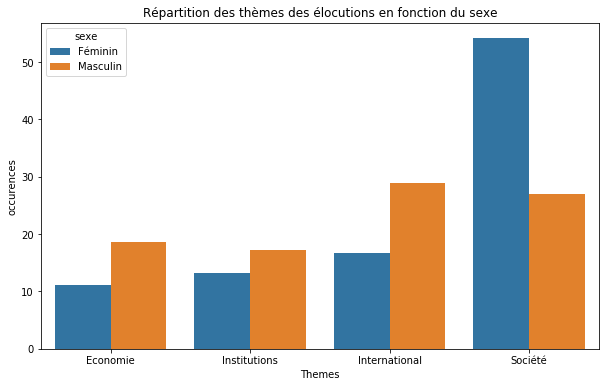

In [148]:
plt.figure(figsize=(10,6))
sns.barplot(data = d[d.Themes != ''],hue = 'sexe',x='Themes',y='occurences')
plt.title('Répartition des thèmes des élocutions en fonction du sexe')
plt.xticks(rotation=0)
plt.show()

In [149]:
# FONCTIONS JAI PAS FAIT GAFFE MON SCRAPPER BUG ENCORE SUR LES FONCTIONS

Désormais nous allons nous concentrer sur le texte uniquement. Pour le faire, nous créeons dans un premier temps un ensemble de fonctions permettant d'étudier le texte.


Nous tokenizons notre text pour pouvoir le travailler et sortir d'autres variables par la suite. 
Nous allons tester plusieurs tokenizer pour voir lequel marche le mieux.

Commençons par le tokenizer français de Spacy.

In [153]:
tokenizer = Tokenizer(nlp.vocab)

In [154]:
print(len([w for w in tokenizer(df.Texte[0])]))

4413


Puis par le tokenizer de nltk

In [155]:
print(len(word_tokenize(df.Texte[0], language='french')))

4665


Tokenizer basé sur le regex, on remarqu'il ne fonctionne pas bien car tokenize "c'est" en deux "c'" et "est".

In [156]:
toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
len(toknizer.tokenize(df.Texte[0]))

5440

On remarque une différence, le tokenizer de nltk tokenize la ponctuation tandis que celui de spacy ne le fait pas visiblement. On va donc utiliser plutôt le tokenizer de nltk.

Pour les stopwords, il semblerait que la liste de spacy soit bien plus complète

In [157]:
len(list(fr_stop)),len(stopwords.words('french'))

(600, 157)

In [150]:
df['NbToken'] = df.Texte.apply(lambda x : len(word_tokenize(x,language='french')))
df['Token'] = df.Texte.apply(lambda x : word_tokenize(x,language='french'))

In [208]:
def cleanToken(x):
    """
        Fonction permettant de nettoyer et de tokenizer un texte
    """
    import string
    pct = string.punctuation+'...'+'\x92'+'«'+'»'+'``'+"''"+'``'
    x = x.replace('\xa0','').replace('\x85','').replace('\x96','')
    x = "".join(filter(lambda y: not y.isdigit(), x))
    sw = list(fr_stop)
    tokens = [str(w).lower() for w in word_tokenize(x, language='french')]
    tokens = [w for w in tokens if w not in pct]
    tokens = [w for w in tokens if w not in sw]
    return tokens
def count_punct(tokens):
    """
        Permet de compter la ponctuation
    """
    import string
    pct = string.punctuation +'...'+'\x92'+'«'+'»'+'``'
    cpt = 0
    for x in tokens:
        if x in pct:
            cpt+=1
    return cpt
def count_stopwords(tokens):
    """
        compte le nombre de stopwords à l'aide de spacy à partir de tokens
    """
    sw = list(fr_stop)
    return len([word for word in tokens if word.lower() in sw])
def Hapaxlegomena(tokens):
    """
        Compte le nombre de mot unique
    """
    s = pd.DataFrame(Counter(tokens).items(),columns=['Mot','nb'])
    return len(s[s.nb ==1])
def Hapaxdislegomena(tokens):
    """
        Compte le nombre de mot présent deux fois seulement
    """
    s = pd.DataFrame(Counter(tokens).items(),columns=['Mot','nb'])
    return len(s[s.nb ==2])
def extractPos(x):
    """
        Extrait le POS de chaque texte. A voir s'il y a un moyen de pas avoir à taper toutes les variables à la main
    """
    doc = nlp(x)
    lst_pos = [token.pos_ for token in doc]
    c = Counter(lst_pos)
    return [c['NOUN'],c['DET'],c['PUNCT'],c['ADJ'],c['ADP'],c['PRON'],c['VERB'],c['CCONJ'],c['NUM'],c['PROPN'],c['ADV'],c['SCONJ'],c['AUX'],c['INTJ']]
def nbArt(x):
    """
        Nombre d'article dans un document
    """
    doc = nlp(x)
    lst_pos = [token.tag_ for token in doc if token.tag_.split('|')[-1] == 'PronType=Art']
    return len(lst_pos)
def f_mesure(NbToken,nbnom,nbadj,nbprep,nbart,nbpro,nbverb,nbadv,nbint):
    """
        Inspiré par Heylighen and Dewaele, 2002
        Définit ici : https://www.cs.uic.edu/~liub/publications/EMNLP-2010-blog-gender.pdf comme étant
        F = 0.5 * [(freq.nom + freq.adjectif + freq.preposition + freq.article) - (freq.pronom + freq.verbe + freq.adverbe +
        freq.interjection) +100]
    """
    nbnom,nbadj,nbprep,nbart,nbpro,nbverb,nbadv,nbint = nbnom/NbToken,nbadj/NbToken,nbprep/NbToken,nbart/NbToken,nbpro/NbToken,nbverb/NbToken,nbadv/NbToken,nbint/NbToken
    nbnom,nbadj,nbprep,nbart,nbpro,nbverb,nbadv,nbint = nbnom*100,nbadj*100,nbprep*100,nbart*100,nbpro*100,nbverb*100,nbadv*100,nbint*100
    return 0.5*((nbnom + nbadj + nbprep + nbart)-(nbpro + nbverb + nbadv + nbint)+100)
def print_nine_dist(lst,df):
    """
        Input : 
            lst : liste de variables à print
            df : dataframe contenant ces valeurs
        Output : 
            Jusqu'à 9 displot des variables (3*3)
    """
    plt.figure(figsize=(10,14))
    for j in range(1,10):
        if len(lst)>j-1:
            var = lst[j-1]
        else:
            break
        q99= df[var].quantile(0.99)
        plt.subplot(330+j)
        sns.distplot(df[df.sexe == 2][var],color = 'red')
        sns.distplot(df[df.sexe == 1][var])
        plt.xlim(left=-0.1,right=q99)
    plt.subplots_adjust(wspace = 1)
    plt.show()
def NbSyllables(x):
    """
        Input : document
        Output : nbVoyelles
    """
    voyelles= 'aeiouy'
    return len([word for word in x if word.lower() in voyelles])
def flesh_reading_ease(ASL,ASW):
    """
        Score de lisibilité du texte : Plus il est élévé plus il est facile à comprendre
        FRE  = 206.835 - (1.015 × ASL) - (84.6 × ASW)
        ASL = NbToken/NbPhrases
        ASW = NbSyllables/NbToken
    """
    return 206.835 - (1.015 * ASL) - (84.6 * ASW)
def sent_detector_mano(x):
    """
        Détection de phrase à la main.
        Input : document
        Output : liste de phrases
        Problème avec les phrases finissant par : entrainant souvent une liste. 
        De même avec ;. Tentative réalisé
        
    """
    lst =[]
    phrase = []
    i = 0
    for caractere in x: 
        if not (caractere == ' ' and len(phrase) == 0) :
            phrase.append(caractere)
        if caractere in '?!.:;':
            if caractere == ':':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            elif caractere == ';':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            elif phrase != '.' or phrase != '?' or phrase != '!':
                lst.append(''.join(phrase))
                phrase = []
        i+=1
    return lst
def extraire_nb_mot(x):
    """
        Input : Document
        Output : nombre de mot
    """
    import string
    pct = string.punctuation+'...'+'\x92'+'«'+'»'+'``'+"''"+'``'
    x = x.replace('\xa0','').replace('\x85','').replace('\x96','')
    x = "".join(filter(lambda y: not y.isdigit(), x))
    tokens = [str(w).lower() for w in word_tokenize(x, language='french')]
    tokens = [w for w in tokens if w not in pct]
    return len(tokens)
def remove_source(x):
    x =  x[:x.find('Source:')]
    return x[:x.find('Source http')]

Il y a un problème avec le détecteur de phrase de nltk... J'ai du en coder un à la main qui à l'air de fonctionner mieux mais c'est pas non plus sur.

In [33]:
print(len(sent_detector.tokenize(df.Texte[1])))
#sent_detector.tokenize(df.Texte[1])

46


In [36]:
print(len(df.Texte[1].split('.')))
#df.Texte[1].split('.'))

77


In [53]:
print(len(sent_detector_mano(df.Texte[1])))
#sent_detector_mano(df.Texte[1])

80


In [210]:
df.Texte = df.Texte.apply(remove_source)

In [211]:
df['NbCleanToken'] = df.Texte.apply(lambda x : len(cleanToken(x)))
df['NbSyllables'] = df.Texte.apply(NbSyllables)
df['NbMot'] = df.Texte.apply(extraire_nb_mot)
#Pb avec le FRE qui donne des négatifs, marche peut être pas en francais... 
df['NbPhrases'] = df.Texte.apply(lambda x:len(sent_detector_mano(x)))
df['FRE'] = df.apply(lambda row : flesh_reading_ease(row.NbMot/row.NbPhrases,row.NbSyllables/row.NbMot),axis=1)
df['CleanToken'] = df.Texte.apply(cleanToken)
df['NbCleanToken']=df.CleanToken.apply(len)
df['NbPonct'] = df.Texte.apply(count_punct)
df['NbSw'] = df.Token.apply(count_stopwords)
df['Hapaxlegomena']=df.CleanToken.apply(Hapaxlegomena)
df['Hapaxdislegomena']= df.CleanToken.apply(Hapaxdislegomena)
df['UniqueWordTx']= df.CleanToken.apply(lambda x:len(set(x))/len(x))
df['RateCleanRaw'] = df.NbCleanToken/df.NbToken
df['NbNom'],df['NbDet'],df['NbPunct'],df['NbAdj'],df['NbAdp'],df['NbPron'],df['NbVerb'],df['NbCconj'],df['NbNum'],df['NbPropn'],df['NbAdv'],df['NbSCONJ'],df['NbAUX'],df['NbIntj']=zip(*df.Texte.apply(extractPos))
df['NbArt']= df.Texte.apply(nbArt)
df['F_mesure'] = df.apply(lambda row: f_mesure(row.NbToken,row.NbNom,row.NbAdj,row.NbAdp,row.NbArt,row.NbPron,row.NbVerb,row.NbAdv,row.NbIntj),axis=1)

In [171]:
lst = ['NbCarac', 'NbSyllables','NbPhrases','FRE','NbMot','NbToken','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 
       'UniqueWordTx', 'RateCleanRaw','NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb',
        'NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','NbArt', 'F_mesure'
        ]
print(len(lst))

29


Ci dessous, il est possible d'observer des différences entre les hommes et les femmes.

In [ ]:
for i in range(0,18,9):
    print_nine_dist(lst[i:i+9],df)

In [ ]:
print_nine_dist(lst[18:26],df)

TEST : Extracting positive negative sentiment

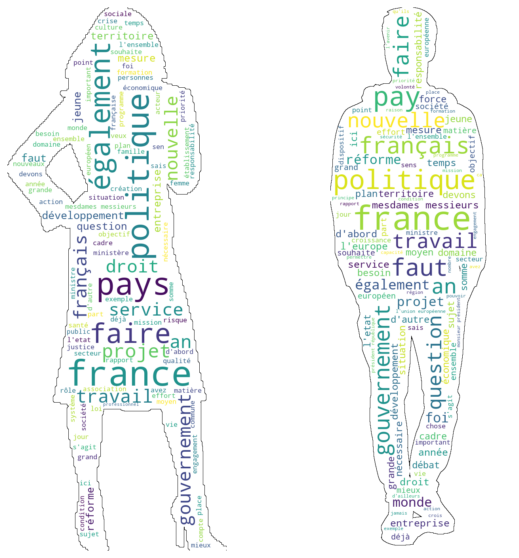

In [212]:
woman = np.array(Image.open("femme2.png"))
wc = WordCloud(background_color="white", max_words=100, mask=woman,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=0.5, contour_color='black')
arr = reduce(add,df[df.sexe == 2].CleanToken.array)
corpus_f = ' '.join(arr)
wc.generate(corpus_f)
man = np.array(Image.open("homme.png"))
wc2 = WordCloud(background_color="white", max_words=100, mask=man,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=1, contour_color='black')
arr = reduce(add,df[df.sexe == 1].CleanToken.array)
corpus_m = ' '.join(arr)
wc2.generate(corpus_m)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

### Tentative de d'extraction des sentiments

Premier test d'une méthode basé sur le lexicon FEEL(French Expanded Emotion Lexicon) qui est une traduction du NRC.
http://advanse.lirmm.fr/feel.php

Il faut avant cela lemmatizer nos mots.

In [217]:
feel = pd.read_csv('feel.csv',sep=';')
feel.set_index('id',inplace=True)
feel.sample(5)

,word,polarity,joy,fear,sadness,anger,surprise,disgust
id,,,,,,,,
11571,relativité,positive,0,0,0,0,0,0
9603,nuageuges,negative,0,0,1,0,0,0
9984,parentales,positive,0,0,0,0,0,0
12385,se repentir,positive,0,1,0,0,0,0
5535,égide,positive,0,0,0,0,0,0


In [226]:
def check_polarity(tokens):
    """
    """
    pos = feel[feel.polarity == 'positive'].word.values
    neg = feel[feel.polarity == 'negative'].word.values
    nb_pos = [word for word in tokens if word in pos]
    nb_neg = [word for word in tokens if word in neg]
    non_trouve = [word for word in tokens if word not in nb_pos+nb_neg]
    return len(tokens),len(nb_pos),len(nb_neg),non_trouve

In [295]:
from nltk.stem.snowball import FrenchStemmer


In [299]:
def cleanTokenLemme(x):
    """
        Fonction permettant de nettoyer et de tokenizer un texte tout en le lemmatizant
    """
    import string
    pct = string.punctuation+'...'+'\x92'+'«'+'»'+'``'+"''"+'``'
    x = [word.lemma_ for word in nlp(x)]
    x = ' '.join(x)
    x =str(x)
    x = x.replace('\xa0','').replace('\x85','').replace('\x96','')
    x = "".join(filter(lambda y: not y.isdigit(), x))
    sw = list(fr_stop)
    tokens = [str(w).lower() for w in word_tokenize(x, language='french')]
    tokens = [w for w in tokens if w not in pct]
    tokens = [w for w in tokens if w not in sw]
    tokens = [w for w in tokens if not len(w) <=2]
    return tokens

In [282]:
check_polarity(cleanTokenLemme(df.Texte[0]))

(1741,
 831,
 135,
 ['guillaume',
  'durand',
  'michaël',
  'darmon',
  'education',
  'sentiment',
  'communiqué',
  'hier',
  'matignon',
  'ump',
  'oui',
  'luc',
  'chatel',
  'ecoutez',
  'falloir',
  'apaisement',
  'cantonal',
  'arrive',
  'partir',
  'regarde',
  'département',
  'tal',
  'ensemble',
  'département',
  'guillaume',
  'durand',
  'profond',
  'fond',
  'anti',
  'pro',
  'débat',
  'débat',
  'luc',
  'chatel',
  'oui',
  'guillaume',
  'durand',
  'luc',
  'chatel',
  'ecoutez',
  'connaissez',
  'amène',
  'présidentiel',
  'ici',
  'projet',
  'guillaume',
  'durand',
  'raffarin',
  'luc',
  'chatel',
  'guillaume',
  'durand',
  'raffarin',
  'parl',
  'luc',
  'chatel',
  'sentiment',
  'sentiment',
  'guillaume',
  'durand',
  'luc',
  'chatel',
  'voir',
  'citer',
  'déloyauté',
  'vis-à-vis',
  'guillaume',
  'durand',
  'phrase',
  'gaulle',
  'falloir',
  'arrière-pensée',
  'luc',
  'chatel',
  'oui',
  'écouter',
  'regarde',
  'essayer',
  'tan

In [ ]:
# Je tente juste les deux packages je veux voir ce que ca donne

In [ ]:
from textblob import TextBlob
for sentence in df['Phrases'][1]:
    print(sentence)
    print(TextBlob(sentence).sentiment.polarity)

In [ ]:
# Je veux voir la différence avec le nltk (je sais pas si ca marche en français)
import nltk
nltk.download('vader_lexicon')#vader c'est pas pour les textes des réseaux sociaux de base?
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
for sentence in df['Phrases'][1]:
    ss = SentimentIntensityAnalyzer().polarity_scores(sentence)
    print(sentence)
    print(ss)

In [ ]:
# Ca donne pas la même chose. Faudrait voir lequel est le mieux... 